In [61]:
import numpy as np
import pandas as pd
from itertools import product
import os
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
#from joblib import Parallel, delayed

#from sklearn.neighbors import kd_tree

from pyproj import CRS, Transformer
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

### Already calculated:
- fix cell positions throughout the year
- (slightly) different overlap matrix for each day

### To-do in this notebook: explore merging 
- load a daily overlap matrix
- check for overlapping cells and measure their distance
- keep only close connections
- merge cells (build graph?)

### Locate data

In [59]:
source = '/media/Data_storage/Mobilcell/DayPolygonData/'
destination = '/media/Data_storage/Mobilcell/DayPolygonData/'

### Load tower locations

In [15]:
tower_loc_df = pd.read_csv( source+'fixed_tower_locations.csv' )
tower_loc_df.head()

,original_id,tower_id,mean_x,mean_y,std_x,std_y,perc_10_x,perc_10_y,perc_50_x,perc_50_y,perc_90_x,perc_90_y,perc_99_x,perc_99_y
0,71892,0,250859,557285,4,2,250851,557281,250862,557287,250862,557287,250862,557287
1,72307,1,243343,558377,4,9,243342,558374,243342,558374,243345,558383,243355,558407
2,72922,2,247254,549716,5,2,247247,549714,247258,549716,247258,549724,247258,549724
3,73325,3,248646,551068,3,3,248646,551066,248646,551066,248652,551072,248652,551081
4,140903,4,273540,796042,47,39,273514,796019,273514,796019,273622,796118,273635,796118


In [14]:
# all unique ids of polygons for the whole year
tower_id_all_global = np.load( source+'unique-tower-id_all.npy' )[:,0] # 0th column contains the ids
tower_to_int_all = dict( zip( tower_id_all_global, np.arange( tower_id_all_global.shape[0] ) ) )
len(tower_to_int_all)

43376

### Load overlap matrix

In [4]:
files_ovr = np.array( sorted( [ i for i in os.listdir( source ) if 'overlap' in i] ) )
files_ovr.shape, files_ovr[:3]

((365,), array(['overlap-matrix_normed_20181201.npz',
        'overlap-matrix_normed_20181202.npz',
        'overlap-matrix_normed_20181203.npz'], dtype='<U34'))

In [5]:
ovr_mat_global = np.zeros( ( len(tower_to_int_all), len(tower_to_int_all) ), np.float16)
#ovr_mat_norm = np.zeros( ( len(tower_to_int_all), len(tower_to_int_all) ), np.uint16)

In [6]:
for t in tqdm( range( files_ovr.shape[0] ) ):
    ovr_mat_global += np.load( source + files_ovr[t] )['ovr']
    #ovr_mat_norm += ( (ovr_mat > 0)*1 ).astype(np.uint16)

100%|██████████| 365/365 [3:03:07<00:00, 30.10s/it]  


#### Try to paralellize (works, but not for this large computation due to 32 bit limit)

#### Todo: Normalize each row with the diagonal element

In [8]:
norm_factor = np.ones( ovr_mat_global.shape[0], dtype=np.float32 )
nonzero = ovr_mat_global[ np.diag_indices(ovr_mat_global.shape[0]) ] > 0
norm_factor[nonzero] = ovr_mat_global[ np.diag_indices(ovr_mat_global.shape[0]) ][nonzero]
ovr_mat_normed = ovr_mat_global / norm_factor
ovr_mat_normed.shape

(43376, 43376)

In [9]:
ovr_mat_normed

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

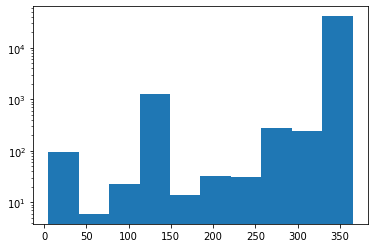

In [12]:
plt.hist( norm_factor )
plt.yscale('log')

#### Cell encodings

In [16]:
tower_to_int = dict( zip(tower_loc_df.original_id, tower_loc_df.tower_id) )
int_to_tower = dict( zip(tower_loc_df.tower_id, tower_loc_df.original_id) )
int_to_pos = dict( zip(tower_loc_df.tower_id, tower_loc_df.iloc[:,2:4].values.tolist() ) )

#### Lets check few

In [17]:
int_to_pos[0], int_to_pos[120]

([250859, 557285], [208627, 818347])

#### Interestingly there are more cells at the exact same position!

In [18]:
int_to_pos[32153-8], int_to_pos[32154-8], int_to_pos[32157-8], int_to_pos[26226], int_to_pos[26227]

([250827, 559437],
 [250827, 559437],
 [250827, 559437],
 [250827, 559437],
 [250827, 559437])

https://www.google.hu/maps/@47.5941336,17.8439783,3a,75y,340.88h,96.97t/data=!3m6!1e1!3m4!1srHwD7QIjd9Vz6Qce20Nw7Q!2e0!7i13312!8i6656?hl=en

### Process

#### This can be done for a day or for a year with the summed matrix

In [19]:
threshold_ovr = 0.25 # fraction of overlap
threshold_dist = 127*10 # distance in m

In [20]:
ovr_mat = ovr_mat_normed
ovr_mat_thrs_idxs = np.argwhere( ovr_mat > threshold_ovr )
ovr_mat_thrs_idxs[:5]

array([[    0,     0],
       [    0, 12375],
       [    0, 12378],
       [    0, 21669],
       [    0, 21670]])

In [21]:
ovr_diff_idx = np.where( np.diff( ovr_mat_thrs_idxs[:,0] ) )[0]+1
# insert first element (zero) ## otherwise left out!
ovr_diff_idx = np.insert(ovr_diff_idx, 0, 0, axis=0)
# insert last element (size of array) ## otherwise left out!
ovr_diff_idx = np.append( ovr_diff_idx, ovr_mat_thrs_idxs.shape[0] )

ovr_mat_indexing = np.vstack( ( ovr_diff_idx[:-1], ovr_diff_idx[1:] ) ).T

In [22]:
ovr_mat_indexing

array([[     0,     15],
       [    15,     27],
       [    27,     31],
       ...,
       [402144, 402147],
       [402147, 402152],
       [402152, 402156]])

In [23]:
def euclidean_distance( x, y ):
    return np.sqrt( np.sum( (x-y)**2 ) )

In [24]:
euclidean_distance( np.array([250859, 557285]), np.array([246001, 552917]) )

6532.961656094424

In [25]:
merge_idxs_all = []
for i in tqdm( range(ovr_mat_indexing.shape[0]) ):
    #print(i)
    # get current tower indices, where distance needs to be checked
    curr_idxs = ovr_mat_thrs_idxs[ ovr_mat_indexing[i,0]:ovr_mat_indexing[i,1] ]
    curr_idxs = curr_idxs[ curr_idxs[:,0] != curr_idxs[:,1] ]
    
    if len(curr_idxs) > 0:
        # current line (current cell to measure distance to)
        base_pos = np.array( int_to_pos[ curr_idxs[0,0] ] )
        #print(base_pos)
        check_pos = np.array( [ int_to_pos[q] for q in curr_idxs[:,1] ] )
        #print(check_pos)
        dists = np.array( [ euclidean_distance(base_pos, s ) for s in check_pos ] )
        merge_idxs = curr_idxs[ np.argwhere( dists < threshold_dist ), 1]
        if len(merge_idxs) > 0:
            merge_idxs = np.insert( merge_idxs, 0, i )
            merge_idxs_all.append( merge_idxs )

100%|██████████| 43376/43376 [00:05<00:00, 8042.85it/s] 


### Merging preparation

#### Add ones in previously calculated positions into an empy matrix

In [26]:
ovr_mat_int = np.zeros( ovr_mat.shape, dtype=np.uint16 )
for n in merge_idxs_all:
    line = n[0]
    idx_to_add_at = n[1:]
    np.add.at( ovr_mat_int[line], idx_to_add_at, 1 )

In [27]:
ovr_mat_int[20:30,20:30]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint16)

In [28]:
merge_idxs_all[:10]

[array([    4, 25241, 32422, 32424, 34224, 34294]),
 array([    6,  1202,  6824,  9871, 16987, 30809]),
 array([    7,  1201,  6808,  9872, 16988, 30808]),
 array([    8,  1199,  6806,  9873, 30807]),
 array([    9,  7345,  9906, 30020]),
 array([   10,  7321,  9907, 30019]),
 array([   11,  7316,  9908, 30018]),
 array([   12,  3199,  5546,  9133, 31289]),
 array([   13,  3198,  5545,  9134, 31288]),
 array([   14,  3197,  5544,  9135, 17047, 31287])]

#### Keep only symmetric connections? (A and B cells would have to both overlap each other up to defined ratio)

In [29]:
merge_idxs_symm = []
for a in tqdm( range( ovr_mat_int.shape[0] ) ):
    inline_idx_symm = np.argwhere( np.logical_and( ovr_mat_int[a] > 0, ovr_mat_int[:,a] > 0 ) ).flatten()
    if inline_idx_symm.shape[0] > 0:
        merge_idxs_symm.append( np.insert( inline_idx_symm, 0, a ) )

100%|██████████| 43376/43376 [00:21<00:00, 2064.59it/s]


In [30]:
merge_idxs_symm[:10]

[array([    4, 25241]),
 array([    6,  1202,  6824,  9871, 16987, 30809]),
 array([    7,  1201,  6808,  9872, 16988, 30808]),
 array([    8,  1199,  6806,  9873, 30807]),
 array([    9,  7345,  9906, 30020]),
 array([   10,  7321,  9907, 30019]),
 array([   11,  7316,  9908, 30018]),
 array([   12,  3199,  5546,  9133, 31289]),
 array([   13,  3198,  5545,  9134, 31288]),
 array([   14,  3197,  5544,  9135, 17047, 31287])]

In [31]:
ovr_mat_int = np.zeros( ovr_mat.shape, dtype=np.uint16 )
for n in merge_idxs_symm:
    line = n[0]
    idx_to_add_at = n[1:]
    np.add.at( ovr_mat_int[line], idx_to_add_at, 1 )

In [32]:
ovr_mat_int[20:30,20:30]

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint16)

#### Build graph then find communities? Remove community linking edges based on graph prop?

In [33]:
ovr_mat_to_graph = (ovr_mat_int > 0)*1

In [34]:
ovr_mat_to_graph

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

##### Make adjacency matrix symmetric (linking to cells to each other is a symmetric relation)

##### Graph creation

In [35]:
G = nx.from_numpy_matrix(ovr_mat_to_graph)
len( G.nodes() ), len( G.edges() )

(43376, 88371)

##### Check for 5 biggest connected components

In [36]:
[ len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)][:5]

[454, 388, 141, 138, 103]

In [37]:
len([ len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

14585

In [38]:
int_to_pos[23], int_to_pos[24], int_to_pos[25]

([236349, 650877], [236349, 650877], [236349, 650877])

##### Check some indexing

In [39]:
int_to_pos[23], int_to_pos[24], int_to_pos[25], int_to_pos[32791]

([236349, 650877], [236349, 650877], [236349, 650877], [178437, 481967])

#### Biggest connected comp

In [40]:
[ c for c in sorted(nx.connected_components(G), key=len, reverse=True)][0]

{39,
 236,
 237,
 238,
 239,
 448,
 489,
 649,
 702,
 704,
 706,
 780,
 782,
 957,
 1134,
 1139,
 1140,
 1142,
 1250,
 1252,
 1380,
 1382,
 1383,
 1474,
 1476,
 1486,
 1488,
 1489,
 1680,
 1683,
 1684,
 1763,
 1765,
 1778,
 1780,
 1852,
 1853,
 1855,
 1869,
 1909,
 1910,
 1963,
 2024,
 2025,
 2233,
 2410,
 2412,
 2473,
 2477,
 2478,
 2560,
 2618,
 2619,
 2637,
 2824,
 2825,
 2879,
 2886,
 2938,
 2971,
 2982,
 3125,
 4143,
 4221,
 4222,
 4495,
 4496,
 4497,
 4555,
 4556,
 4557,
 4846,
 4890,
 4918,
 4987,
 4989,
 5114,
 5506,
 5539,
 5540,
 5560,
 5569,
 5570,
 5619,
 5702,
 5704,
 5811,
 5812,
 5933,
 5934,
 5935,
 5936,
 5937,
 5938,
 5971,
 6012,
 6013,
 6017,
 6021,
 6022,
 6023,
 6051,
 6052,
 6053,
 6078,
 6079,
 6080,
 6243,
 6271,
 6272,
 6273,
 6294,
 6321,
 6322,
 6323,
 6325,
 6386,
 6458,
 6459,
 6460,
 6793,
 6795,
 6810,
 7662,
 7664,
 7893,
 7950,
 8636,
 8638,
 8649,
 8654,
 8946,
 8947,
 8948,
 8949,
 9054,
 9055,
 9056,
 9057,
 9142,
 10079,
 11141,
 11356,
 11405,
 11

### Prepare output to save

In [41]:
group_idxs = [ list(c) for c in sorted(nx.connected_components(G),  key=len, reverse=True) ]
len(group_idxs)

14585

In [42]:
groups_save = np.zeros( len(int_to_tower), dtype=np.uint16 )
for n in range( len(group_idxs) ):
    idx_to_add_at = group_idxs[n]
    np.add.at( groups_save, idx_to_add_at, n )

In [60]:
np.save( destination, np.vstack( (tower_loc_df.tower_id.values, groups_save) ).T )

In [43]:
groups_save

array([9058, 9059, 9060, ..., 4786, 3399, 4787], dtype=uint16)

In [52]:
tower_loc_df.tower_id.values

array([    0,     1,     2, ..., 43373, 43374, 43375])

In [49]:
groups_save[39], groups_save[236], groups_save[237]

(0, 0, 0)

In [67]:
tower_loc_df.mean_x.values, tower_loc_df.mean_y.values

(array([250859, 243343, 247254, ..., 288436, 286467, 287483]),
 array([557285, 558377, 549716, ..., 826650, 826669, 824713]))

In [127]:
cell_groups = np.vstack( (tower_loc_df.original_id.values,
                          tower_loc_df.tower_id.values,
                          tower_loc_df.mean_x.values, 
                          tower_loc_df.mean_y.values, 
                          groups_save) ).T
cell_groups[:5]

array([[ 71892,      0, 250859, 557285,   9058],
       [ 72307,      1, 243343, 558377,   9059],
       [ 72922,      2, 247254, 549716,   9060],
       [ 73325,      3, 248646, 551068,   9061],
       [140903,      4, 273540, 796042,   5295]])

In [128]:
sort_idx = np.argsort( cell_groups[:,-1] )
cell_groups = cell_groups[sort_idx]

diff_idx = np.where( np.diff( cell_groups[:,-1] ) )[0]+1
# insert first element (zero) ## otherwise left out!
diff_idx = np.insert( diff_idx, 0, 0, axis=0 )
# insert last element (size of array) ## otherwise left out!
diff_idx = np.append( diff_idx, cell_groups.shape[0] )

cell_groups_indexing = np.vstack( ( diff_idx[:-1], diff_idx[1:] ) ).T
cell_groups_indexing[:5]

array([[   0,  454],
       [ 454,  842],
       [ 842,  983],
       [ 983, 1121],
       [1121, 1224]])

In [129]:
cell_groups

array([[ 42751908,     11770,    239320,    650140,         0],
       [ 62654186,     12921,    239778,    650496,         0],
       [  1915243,      5935,    238508,    651131,         0],
       ...,
       [530179853,     43231,    138098,    546224,     14582],
       [530180036,     43232,    136503,    541487,     14583],
       [530180236,     43233,    141515,    542085,     14584]])

In [130]:
cell_groups_coords = np.zeros( (cell_groups.shape[0], 2), dtype=np.uint32 )
for l in cell_groups_indexing:
    current_coords = np.round( np.mean( cell_groups[ l[0]:l[1], 2:4 ], axis=0 ), 0 ).astype(np.uint32)
    cell_groups_coords[ l[0]:l[1] ] = current_coords

In [131]:
cell_groups_coords[sort_idx]

array([[179453, 503430],
       [123133, 689076],
       [228026, 662964],
       ...,
       [264917, 544858],
       [263670, 546490],
       [255032, 544168]], dtype=uint32)

In [132]:
cell_groups_save = np.concatenate( (cell_groups[:,[0, 4]], cell_groups_coords), axis=1 )
sort_idx = np.argsort( cell_groups_save[:,0] )
cell_groups_save = cell_groups_save[ sort_idx ]

In [137]:
pd.DataFrame( cell_groups_save, 
              columns=['original_id', 'tower_id', 
                       'mean_x', 'mean_y'] ).to_csv( destination+'fixed_merged_tower_locations.csv', 
                                                       index=False )

### Some test outputs

In [ ]:
[ [ k, int_to_pos[k] ] for k in list( [ c for c in sorted(nx.connected_components(G), key=len, reverse=True)][0] ) ]

In [ ]:
[ [ k, int_to_pos[k] ] for k in list( [ c for c in sorted(nx.connected_components(G), key=len, reverse=True)][1] ) ]

#### Load polygon file for this day to check back results

In [ ]:
len([ len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

In [ ]:
poligons_df = pd.read_csv( '/media/Data_storage/Mobilcell/Data/MT_MTA_NETWORK_POLIGONS_20181201.csv.gz', delimiter=';')
poligons_df.head()

In [ ]:
int_to_tower[21026], int_to_tower[42146], int_to_tower[42147], int_to_tower[42148], int_to_tower[21024]

In [ ]:
ovr_mat_int[42147, 21026], ovr_mat_int[42146, 21026], ovr_mat_int[42146, 42147]

In [ ]:
poligons_df[ (poligons_df.network_identifier.values == 144500198) ]

In [ ]:
poligons_df[ (poligons_df.network_identifier.values == 393353115) ]

In [ ]:
poligons_df[ (poligons_df.network_identifier.values == 393353177) ]

In [ ]:
poligons_df[ (poligons_df.network_identifier.values == 393353231) ]

In [ ]:
poligons_df[ (poligons_df.network_identifier.values == 144500080) ]

In [ ]:
ovr_mat_int[ 26226, 26227 ], int_to_tower[26226], int_to_tower[26227], int_to_tower[32146]

In [ ]:
poligons_df[ (poligons_df.network_identifier.values == 196621467) ]

In [ ]:
poligons_df[ (poligons_df.network_identifier.values == 196621544) ]

In [ ]:
poligons_df[ (poligons_df.network_identifier.values == 252707087) ]

In [ ]:
int_to_pos[0], int_to_tower[0]

In [ ]:
poligons_df[ (poligons_df.network_identifier.values == 71892) ]

In [ ]:
from matplotlib.patches import Rectangle

In [ ]:
X = poligons_df[ (poligons_df.network_identifier.values == 144500198) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 144500198) ].eovy.values
print( X.shape, Y.shape )

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

X = poligons_df[ (poligons_df.network_identifier.values == 393353115) ].eovx.values
Y = poligons_df[ (poligons_df.network_identifier.values == 393353115) ].eovy.values
print( X.shape, Y.shape )

ax.scatter(X, Y, color = 'red', s=10)

# Add rectangles of size dx and dy
width = 127
height = 127
a_zipped = zip(X, Y)
for a_x, a_y in a_zipped:
    ax.add_patch(Rectangle(xy=(a_x-width/2, a_y-height/2) ,width=width, height=height, linewidth=1, color='red', fill=False))
ax.axis('equal')

In [ ]:
[ [ k ,int_to_pos[k] ] for k in list( [ c for c in sorted(nx.connected_components(G), key=len, reverse=True)][2] ) ]

In [ ]:
[ [ k ,int_to_pos[k] ] for k in list( [ c for c in sorted(nx.connected_components(G), key=len, reverse=True)][3] ) ]